# <center> CNN Model for Text
</center>

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Embedding,GlobalMaxPooling1D, Conv1D
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)

# Generic Functions

In [3]:
labels=pickle.load( open('labels.pkl', 'rb'))
features=pickle.load( open('features.pkl', 'rb'))
features_tfidf= pickle.load( open('features_tfidf.pkl', 'rb'))
word_tfidf_weights=pickle.load( open('word_tfidf_weights.pkl', 'rb'))
non_text_features_np = features.drop(columns=['title', 'text', 'combined_text', 'label']).to_numpy()

In [4]:
def plot_loss_acc(history):
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Data Processing

In [5]:
train_texts = features["combined_text"]
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_texts) 
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_data = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=400)
vocab_size = len(tokenizer.word_index) + 1

In [6]:
train_ft,test_ft,train_labels,test_labels=train_test_split(train_data,labels,test_size=0.2, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(train_ft, train_labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", test_ft.shape)

Training set shape: (45783, 400)
Validation set shape: (11446, 400)
Test set shape: (14308, 400)


# CNN Model

In [20]:
class cnn_model(tf.keras.models.Model):
    def __init__(self,vocab_size):
        super(cnn_model,self).__init__()
        self.embed= Embedding(input_dim=vocab_size, output_dim=200, input_length=400)
        self.conv_1=Conv1D(filters=32, kernel_size=4, activation="relu",padding="same")
        #self.global_pool_1=GlobalMaxPooling1D()
        self.conv_2=Conv1D(filters=16, kernel_size=3,activation="relu",padding="same")
        self.global_pool_2=GlobalMaxPooling1D()
        self.dense_1=Dense(32,activation="relu")
        self.dense_2=Dense(1,activation="sigmoid")
        
    def call(self,inputs):
        x=self.embed(inputs)
        x=self.conv_1(x)
        #x=self.global_pool_1(x)
        x=self.conv_2(x)
        x=self.global_pool_2(x)
        x=self.dense_1(x)
        x=self.dense_2(x)
        
        return x

In [21]:
cnn=cnn_model(vocab_size)
cnn.build((None,400))
print(cnn.summary())

Model: "cnn_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     multiple                  69779400  
                                                                 
 conv1d_10 (Conv1D)          multiple                  25632     
                                                                 
 conv1d_11 (Conv1D)          multiple                  1552      
                                                                 
 global_max_pooling1d_10 (Gl  multiple                 0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            multiple                  544       
                                                                 
 dense_11 (Dense)            multiple                  33        
                                                       

## Configuring model

In [23]:
# Comfiguring the model
opt=keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# early stopping if the validation loss doesnt improve after 3 epochs
early_stop= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# saving the model
save_model=tf.keras.callbacks.ModelCheckpoint("cnn_model", save_best_only=True)

In [24]:
history=cnn.fit(
    train_ft, 
    train_labels, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[save_model,early_stop])

Epoch 1/20


C:\Users\jashi\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1789/1789 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9422

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


1789/1789 [==============================] - 1582s 884ms/step - loss: 0.1373 - accuracy: 0.9422 - val_loss: 0.0324 - val_accuracy: 0.9904
Epoch 2/20
1789/1789 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9920

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


1789/1789 [==============================] - 1530s 855ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.0072 - val_accuracy: 0.9980
Epoch 3/20
1789/1789 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9989

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


1789/1789 [==============================] - 1516s 848ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0057 - val_accuracy: 0.9997
Epoch 4/20
1789/1789 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9991

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


1789/1789 [==============================] - 1573s 880ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 6.4260e-04 - val_accuracy: 0.9999
Epoch 5/20
1789/1789 [==============================] - 1564s 874ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 6/20
1789/1789 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9991

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


1789/1789 [==============================] - 1634s 913ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 4.5386e-04 - val_accuracy: 0.9999
Epoch 7/20
1789/1789 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9997

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


1789/1789 [==============================] - 1617s 904ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 3.7970e-04 - val_accuracy: 0.9999
Epoch 8/20
1789/1789 [==============================] - 1563s 874ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 9/20
1789/1789 [==============================] - 1523s 852ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 4.4306e-04 - val_accuracy: 0.9998
Epoch 10/20
1789/1789 [==============================] - 1520s 850ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0086 - val_accuracy: 0.9977


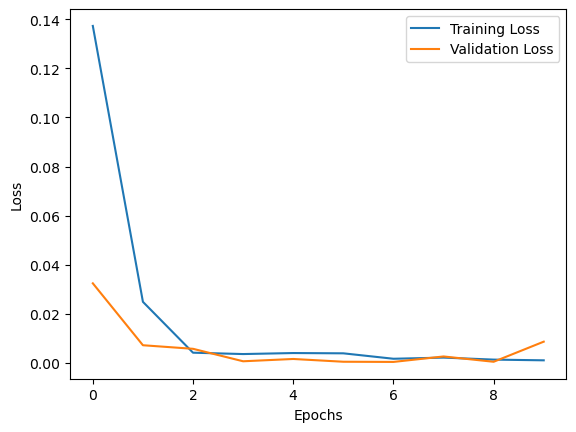

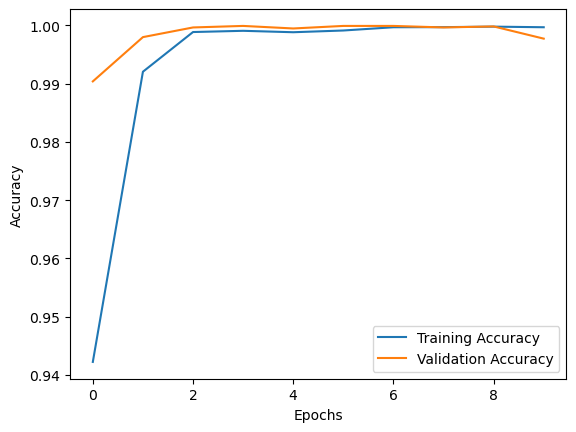

In [25]:
plot_loss_acc(history)

# Loading model

In [26]:
loaded_model = tf.keras.models.load_model('cnn_model')

In [28]:
metrics=loaded_model.evaluate(test_ft,test_labels)
print(f" Accuracy : {metrics[1]*100} \n Loss : {metrics[0]}")

448/448 [==============================] - 6s 14ms/step - loss: 0.1448 - accuracy: 0.9709
 Accuracy : 97.08554744720459 
 Loss : 0.14482292532920837
